In [1]:
import os
import sys
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
from data_handle import(
    ForexDataClean,
    ForexDataLoad
)

from features import ForexFeauturesExtractor

from plots import ForexPlotter
from models import TimeSeriesAutoencoder
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

data = ForexDataLoad(file_path = '../data/xauaud.csv').data

cleaner = ForexDataClean(data = data)
data = cleaner.fast_cleaner()

features = ForexFeauturesExtractor(
    data = data
)

indicators_data, signals_data, extreme_data = features.extract_all_features()

FOREX DATA LOADER
 Available Fuctions 
1 load_csv 
2 load_from_database
Data loaded successfully!
Shape: (38217, 5)

FOREX DATA CLEANER
 Available Fuctions 
1 remove_duplicates 
2 handle_missing_values 
3 validate_ohlc_integrity 
4 handle_outliers 
5 fast_cleaner
Keep = first and subset = None
Removed 0 duplicate entries
OHLC DATA INTEGRITY VALIDATION
No OHLC integrity violations found
All OHLC values are consistent
Found 1 missing values
 dropped: 1 missing values .
OHLC DATA INTEGRITY VALIDATION
No OHLC integrity violations found
All OHLC values are consistent


In [2]:
trend_dir = signals_data['momentum']

In [3]:
trend_dir.shape

(38016, 24)

In [4]:
autoencoder = TimeSeriesAutoencoder(
    input_dim=trend_dir.shape[1] - 1,  
    encoding_dim=2,
    learning_rate=0.001
)

In [5]:
train_data, test_data = autoencoder.prepare_data(
    trend_dir, 
    target_column='close',
    test_size=0.2
)

Training samples: 30412
Test samples: 7604


In [6]:
history = autoencoder.train(epochs=20, batch_size=12, verbose=1)

Epoch 1/20
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.5371 - mae: 0.5606 - val_loss: 0.2998 - val_mae: 0.3379
Epoch 2/20
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.3442 - mae: 0.3893 - val_loss: 0.2699 - val_mae: 0.3073
Epoch 3/20
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.3188 - mae: 0.3639 - val_loss: 0.2542 - val_mae: 0.2914
Epoch 4/20
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.3052 - mae: 0.3503 - val_loss: 0.2469 - val_mae: 0.2877
Epoch 5/20
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2982 - mae: 0.3436 - val_loss: 0.2427 - val_mae: 0.2773
Epoch 6/20
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.2963 - mae: 0.3416 - val_loss: 0.2381 - val_mae: 0.2748
Epoch 7/20
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2895 - mae: 0.3365 - val_loss: 0.2343 - val_mae: 0.2706
Epoch 8/20
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2844 - mae: 0.3319 - val_loss: 0.2299 - val_mae: 0.2609
Epoch 9/20
2535/2535 ━━━━━━━━━━━━━━━━━━━

In [7]:
labels_data_with_latent = autoencoder.add_latent_features(trend_dir)

In [8]:
metrics = autoencoder.evaluate()
print("\nModel Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


Model Metrics:
final_training_loss: 0.2597
final_validation_loss: 0.2082
training_reconstruction_error: 0.2231
test_reconstruction_error: 0.2082
generalization_gap: -0.0148


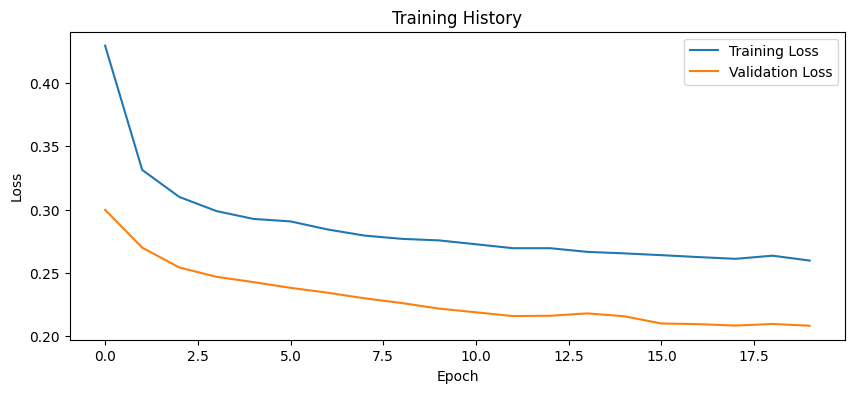

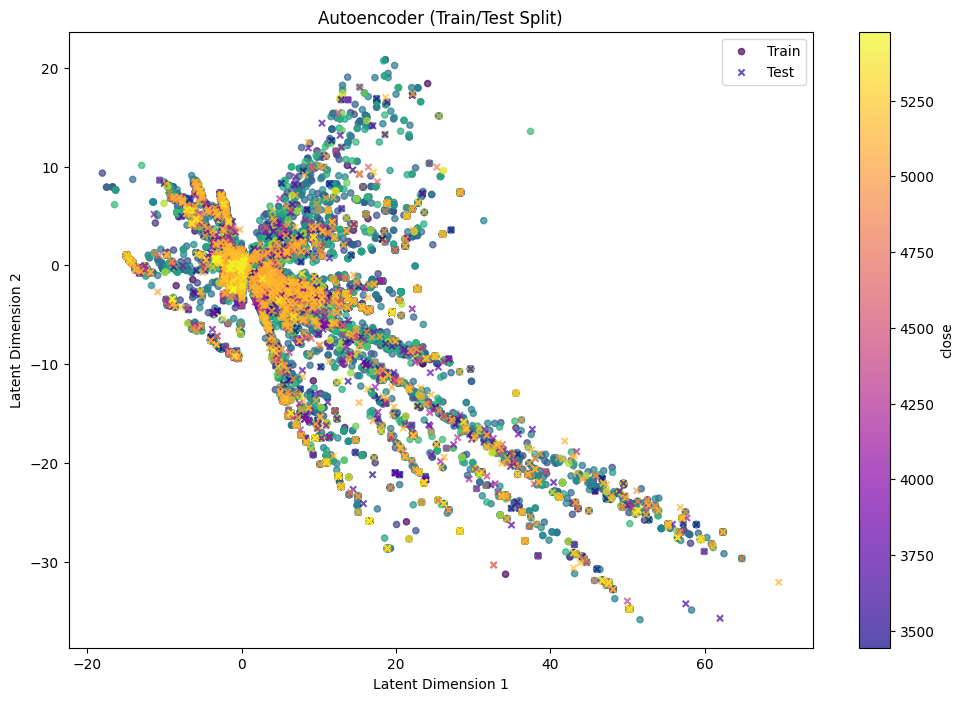

In [9]:
autoencoder.plot_training_history()
autoencoder.plot_latent_space(labels_data_with_latent, color_by='close')

In [10]:
df = labels_data_with_latent[['close', 'latent_dim_1', 'latent_dim_2']]

In [11]:
print(df.tail())

                       close  latent_dim_1  latent_dim_2
datetime                                                
2025-09-05 16:00:00  5455.01     -6.287487      5.523672
2025-09-05 17:00:00  5474.64     -3.387662      0.635265
2025-09-05 18:00:00  5468.49      6.353360    -14.964953
2025-09-05 19:00:00  5476.84     -3.387662      0.635265
2025-09-05 20:00:00  5477.23     -1.031630     -2.442543


In [12]:
close_prices = labels_data_with_latent['close'].values

min_indices = argrelextrema(close_prices, np.less, order=5)[0]

max_indices = argrelextrema(close_prices, np.greater, order=5)[0]

labels_data_with_latent['is_extrema'] = 0
labels_data_with_latent.loc[labels_data_with_latent.index[min_indices], 'is_extrema'] = 1 
labels_data_with_latent.loc[labels_data_with_latent.index[max_indices], 'is_extrema'] = 2  

normal_points = labels_data_with_latent[labels_data_with_latent['is_extrema'] == 0]
minima_latent = labels_data_with_latent[labels_data_with_latent['is_extrema'] == 1]
maxima_latent = labels_data_with_latent[labels_data_with_latent['is_extrema'] == 2]

for extrema_type, data, label in [
    (0, normal_points, 'Normal Points'),
    (1, minima_latent, 'Minima (Buy)'),
    (2, maxima_latent, 'Maxima (Sell)')
]:
    
    print(f"\n {label} (n={len(data)}):")
    print(f"Latent Dim 1: {data['latent_dim_1'].mean():.4f} ± {data['latent_dim_1'].std():.4f}")
    print(f"Latent Dim 2: {data['latent_dim_2'].mean():.4f} ± {data['latent_dim_2'].std():.4f}")


 Normal Points (n=33297):
Latent Dim 1: 6.2409 ± 11.6596
Latent Dim 2: -3.8770 ± 8.5333

 Minima (Buy) (n=2374):
Latent Dim 1: 17.2063 ± 12.5054
Latent Dim 2: -7.1330 ± 9.3083

 Maxima (Sell) (n=2345):
Latent Dim 1: -3.1075 ± 3.6279
Latent Dim 2: 0.6836 ± 2.5694


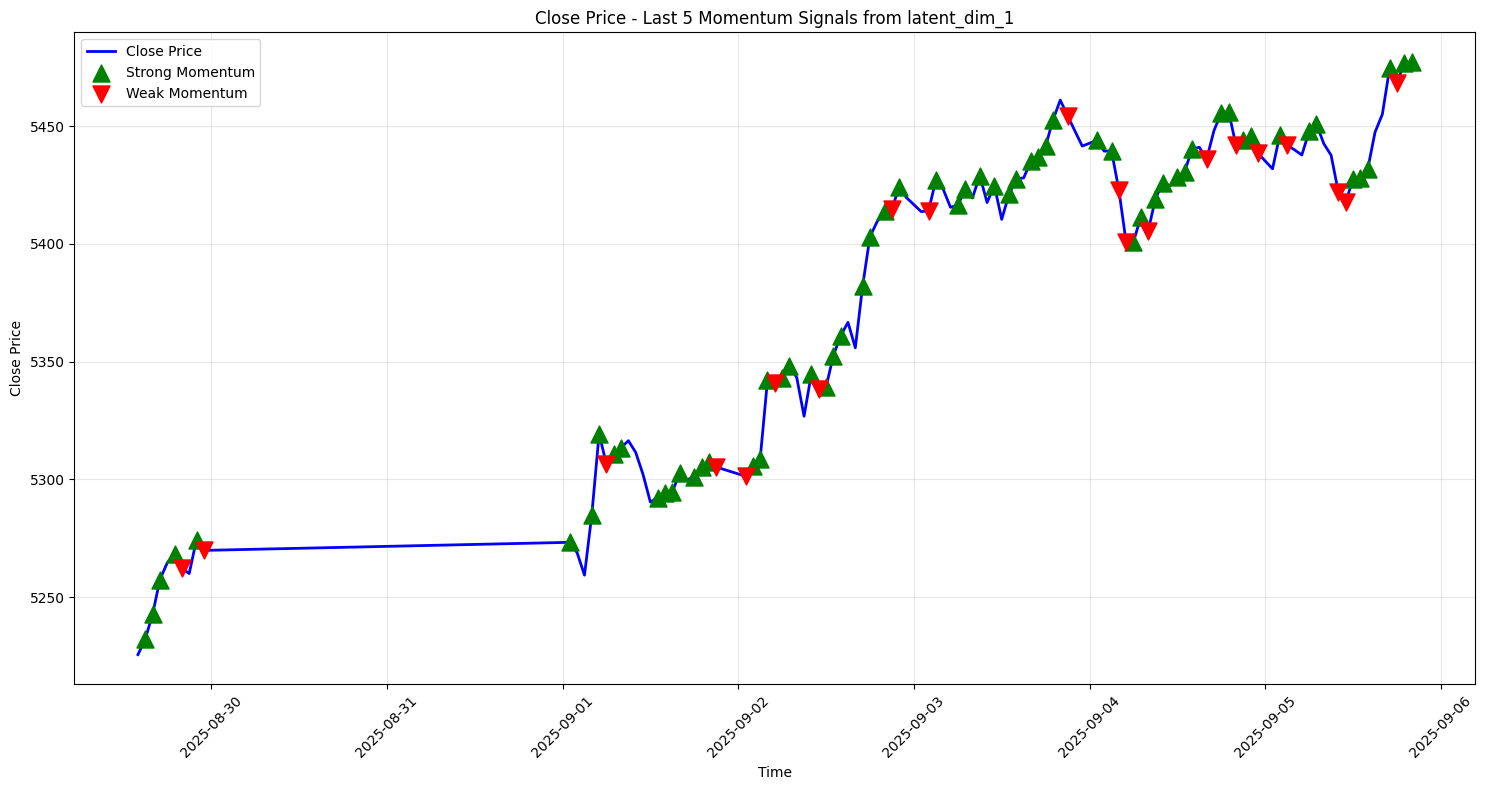

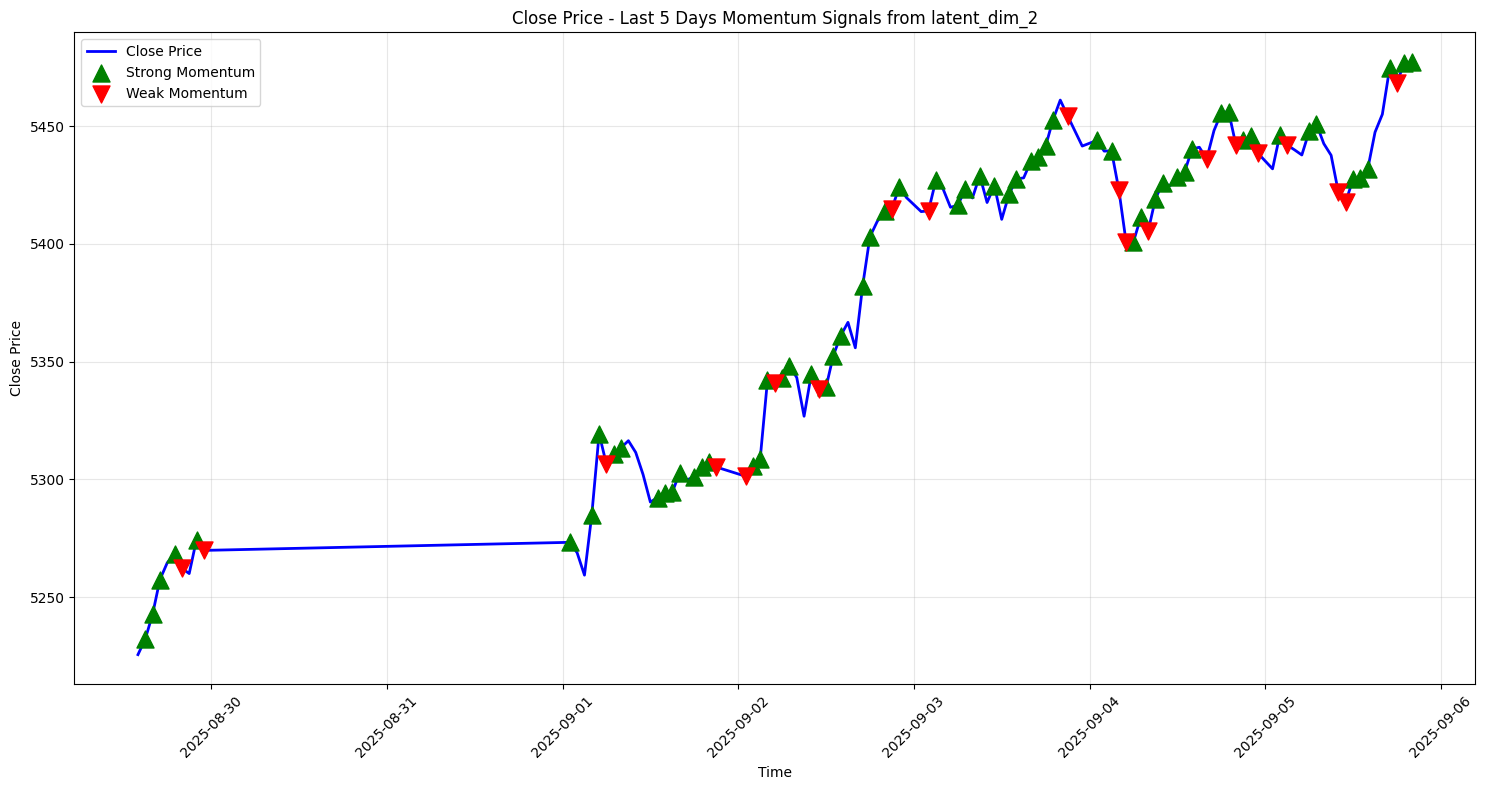

Strong Momentum:63
Weak Momentum:20


In [20]:
def auto_signal(latent_1, latent_2):
    buy_zone_l1 = (
        minima_latent['latent_dim_1'].mean() - 1.5 * minima_latent['latent_dim_1'].std(),
        minima_latent['latent_dim_1'].mean() + 1.5 * minima_latent['latent_dim_1'].std()
    )

    buy_zone_l2 = (
        minima_latent['latent_dim_2'].mean() - 1.5 * minima_latent['latent_dim_2'].std(),
        minima_latent['latent_dim_2'].mean() + 1.5 * minima_latent['latent_dim_2'].std()
    )

    sell_zone_l1 = (
        maxima_latent['latent_dim_1'].mean() - 1.5 * maxima_latent['latent_dim_1'].std(),
        maxima_latent['latent_dim_1'].mean() + 1.5 * maxima_latent['latent_dim_1'].std()
    )

    sell_zone_l2 = (
        maxima_latent['latent_dim_2'].mean() - 1.5 * maxima_latent['latent_dim_2'].std(),
        maxima_latent['latent_dim_2'].mean() + 1.5 * maxima_latent['latent_dim_2'].std()
    )
    
    if (sell_zone_l1[0] <= latent_1 <= sell_zone_l1[1] and sell_zone_l2[0] <= latent_2 <= sell_zone_l2[1]):
        return 'sell'
    elif (buy_zone_l1[0] <= latent_1 <= buy_zone_l1[1] and buy_zone_l2[0] <= latent_2 <= buy_zone_l2[1]):
        return 'buy'
    else:
        return 'hold'

last_5_days = labels_data_with_latent.tail(24 * 5)
last_5_days['signal'] = last_5_days.apply(
    lambda row: auto_signal(row['latent_dim_1'], row['latent_dim_2']), axis=1
)

plt.figure(figsize=(15, 8))
plt.plot(
    last_5_days.index, 
    last_5_days['close'], 
    linewidth=2, 
    label='Close Price',
    color='blue'
)

buy_signals_1 = last_5_days[last_5_days['signal'] == 'sell']
sell_signals_1 = last_5_days[last_5_days['signal'] == 'buy']

plt.scatter(
    buy_signals_1.index, 
    buy_signals_1['close'], 
    color='green', 
    marker='^', 
    s=150, 
    label='Strong Momentum',
    zorder=5
)

plt.scatter(
    sell_signals_1.index,
    sell_signals_1['close'], 
    color='red',
    marker='v', 
    s=150,
    label='Weak Momentum',
    zorder=5
)

plt.title('Close Price - Last 5 Momentum Signals from latent_dim_1')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(
    last_5_days.index,
    last_5_days['close'],
    linewidth=2,
    label='Close Price',
    color='blue'
)

buy_signals_2 = last_5_days[last_5_days['signal'] == 'sell']
sell_signals_2 = last_5_days[last_5_days['signal'] == 'buy']

plt.scatter(
    buy_signals_2.index,        
    buy_signals_2['close'], 
    color='green',
    marker='^', 
    s=150, 
    label='Strong Momentum', 
    zorder=5
)

plt.scatter(
    sell_signals_2.index, 
    sell_signals_2['close'], 
    color='red',
    marker='v',
    s=150,
    label='Weak Momentum',
    zorder=5
)

plt.title('Close Price - Last 5 Days Momentum Signals from latent_dim_2')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


print(f"Strong Momentum:{len(buy_signals_1)}")
print(f"Weak Momentum:{len(sell_signals_1)}")